**Nama:** Devin Augustin

**NIM:** 2440094352

In [ ]:
!pip install unidecode

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np

import re, string
from unidecode import unidecode
import nltk
from nltk.tokenize import word_tokenize

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

#**Jawaban Nomor 1**

Anda bekerja disebuah perusahaan yang membantu untuk memilah produk suatu
e_commerce. Anda diberikan data text deskripsi produk dari website e-commerce dengan 4 label, yaitu
Household, Books, Electronics dan Clothing & Accessories (data_1-.csv). Lakukan pemodelan klasifikasi
dengan menggunakan data tersebut, dengan ketentuan sebagai berikut:

###a. [10%] Lakukan proses pre-processing hingga anda mendapatkan set token yang sudah berada dalam bentuk dasar sesuai standard tata bahasa.


Import Data

In [ ]:
df = pd.read_csv("/content/data_1C.csv")

In [ ]:
#Melihat 5 data teratas
df.head(5)

,Unnamed: 0,text,label
0,0,"Aurion C3 Iron Curl Bar with 2 Locks, 3 ft (Si...",Household
1,1,"Presto 06620 11-Inch Electric Skillet Fries, g...",Household
2,2,WHOOSH! Award-Wining Screen Cleaner - Safe for...,Electronics
3,3,ManQ Men's Blended Waist Coat,Clothing & Accessories
4,4,Lace And Me Women's Blended High Waist Tummy &...,Clothing & Accessories


Data Preprocessing

In [ ]:
def cleansing(df):
    df_clean=df.str.lower() #mengubah semua teks menjadi huruf kecil
    df_clean=[re.sub(r"\d+","",i )for i in df_clean] #menghapus digit apa pun dalam teks dengan menggantinya dengan string kosong
    df_clean=[re.sub(r'[^\w]', ' ', i)for i in df_clean] #menghapus karakter non-alphanumeric dengan menggantinya dengan spasi
    df_clean=[re.sub(r'\s+',' ',i)for i in df_clean] #menghilangkan spasi ekstra dengan mengganti beberapa spasi berturut-turut dengan satu spasi
    df_clean = [unidecode(i) for i in df_clean] #menghilangkan huruf yang memiliki aksen
    df_clean = [re.sub(r'[^a-zA-Z\s]', '', i) for i in df_clean] #menghilangkan non-english alphabet
    return df_clean

In [ ]:
clean_text = cleansing(df['text']) #memanggil function 'cleansing' dengan menggunakan data kolom 'text' dari df dan mengembalikkan nilainya ke dalam variable 'clean_text'

In [ ]:
clean_text[0:5]

['aurion c iron curl bar with locks ft silver mm thickness the brand deals in all types of fitness equipment and accessories and provides high end products to its customers ranging from gym equipment to dumbbells and training equipment the brand has it all ',
 'presto inch electric skillet fries grills stews and more accommodates large roasts hams and poultry innovative evernu cover won t dent warp bend or peel diamondcoat deluxe nonstick finish inside and out dishwasher safe w',
 'whoosh award wining screen cleaner safe for all screens smartphones ipads eyeglasses kindle touchscreen tvs includes unit of ml fl oz w cloth bonus emoji cloth',
 'manq men s blended waist coat',
 'lace and me women s blended high waist tummy thigh shapewear beige free size laceandme firm control tummy mid thigh shaping high waist shapewear great tummy compression lifts rear smooth look no visible panty lines new sleek yarns will not cling to clothes stretch microfiber material cotton spandex nylon free size

In [ ]:
#Tokenization
#Tokenization adalah proses memecah teks menjadi unit yang lebih kecil, seperti kata atau kalimat
word_list = [sentence.split() for sentence in clean_text]

In [ ]:
#Remove Stopwords
#Menghapus stopwords mengacu pada proses menghilangkan kata-kata umum (seperti "the", "is", "and") dari teks
#yang dianggap tidak penting untuk analisis atau tidak berkontribusi banyak pada keseluruhan makna.
from nltk.corpus import stopwords
nltk.download('stopwords')

list_stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Menghilangkan stopwords yang terdapat pada "word_list"
token_clean =[[word for word in sentence if not word in list_stopwords] for sentence in word_list]

In [ ]:
#Lemmatization
#Lemmatisasi adalah proses mereduksi kata menjadi bentuk dasarnya atau kamus (lemma) untuk mencapai analisis dan pemahaman teks yang lebih baik.
from nltk import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
#Melakukan proses lemmatization kepada "token_clean"
final_token = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in token_clean]

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
final_token[0]

['aurion',
 'c',
 'iron',
 'curl',
 'bar',
 'lock',
 'ft',
 'silver',
 'mm',
 'thickness',
 'brand',
 'deal',
 'type',
 'fitness',
 'equipment',
 'accessory',
 'provides',
 'high',
 'end',
 'product',
 'customer',
 'ranging',
 'gym',
 'equipment',
 'dumbbell',
 'training',
 'equipment',
 'brand']

In [ ]:
#Menambahkan kolom tokens yang berisi set token yang telah dibersihkan
df['tokens'] = [' '.join(sentence) for sentence in final_token]

In [ ]:
df.head()

,Unnamed: 0,text,label,tokens
0,0,"Aurion C3 Iron Curl Bar with 2 Locks, 3 ft (Si...",Household,aurion c iron curl bar lock ft silver mm thick...
1,1,"Presto 06620 11-Inch Electric Skillet Fries, g...",Household,presto inch electric skillet fry grill stew ac...
2,2,WHOOSH! Award-Wining Screen Cleaner - Safe for...,Electronics,whoosh award wining screen cleaner safe screen...
3,3,ManQ Men's Blended Waist Coat,Clothing & Accessories,manq men blended waist coat
4,4,Lace And Me Women's Blended High Waist Tummy &...,Clothing & Accessories,lace woman blended high waist tummy thigh shap...


##b. [15%] Set token ini perlu dilakukan vectorization dan pemodelan klasifikasi, gunakan 2 metode
vectorization dan 2 algoritma machine learning. Bandingkan hasilnya dan jelaskan analisa yang anda
lakukan terhadap hasil klasifikasi.

Splitting the data

In [ ]:
#Disini kita akan mendifine X dan Y
X = df['tokens']
Y = df['label']

In [ ]:
#Melakukan splitting data dengan train sebesar 80% dan test 20%
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=12)

####**TF-IDF**

TF-IDF (Term Frequency-Inverse Document Frequency) adalah ukuran numerik yang digunakan dalam analisis teks untuk menilai pentingnya suatu istilah dalam dokumen relatif terhadap kemunculannya di seluruh korpus. Ini menggabungkan frekuensi istilah dalam dokumen (TF) dengan kelangkaannya di seluruh korpus (IDF). Semakin tinggi nilai TF-IDF untuk suatu istilah dalam suatu dokumen, semakin representatif dan khas untuk dokumen tersebut. Dengan mempertimbangkan karakteristik lokal dan global, TF-IDF membantu mengidentifikasi istilah yang bermakna dan unik yang dapat berguna untuk tugas seperti pencarian informasi, klasifikasi teks, dan ekstraksi kata kunci.

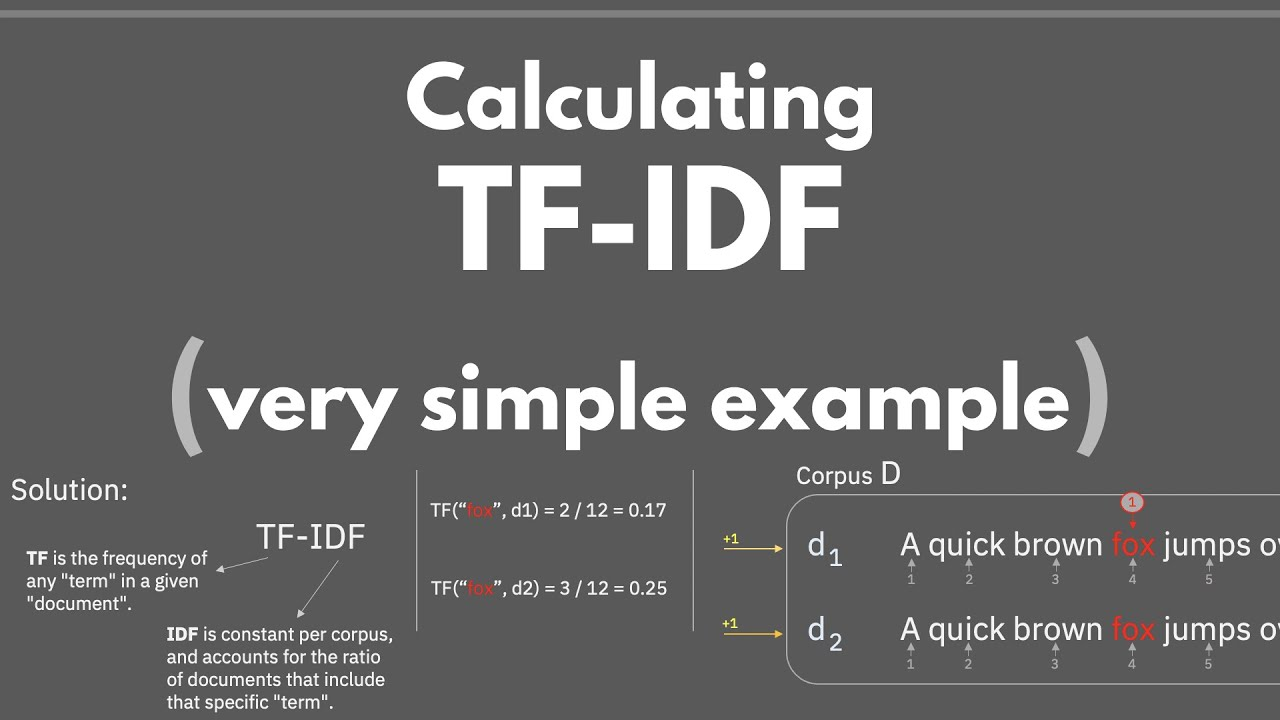

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Mengvektorisasi teks dengan menggunakan tf-idf dan menghilangkan stop words dalam bahasa Inggris dan mengabaikan kata-kata yang muncul dalam lebih dari 100% dokumen.
tfidf_vector = TfidfVectorizer(stop_words='english', max_df=100)

#Mempelajari kamus kata-kata yang muncul dalam data latih X_train.
tfidf_vector.fit(X_train)

#Mentransformasi X_train dan X_test menjadi vektor tf-idf
X_train_tfidf_vector = tfidf_vector.transform(X_train)
X_test_tfidf_vector = tfidf_vector.transform(X_test)

#Mengembalikan bentuk (shape) matriks vektor TF-IDF yang merupakan epresentasi dari jumlah dokumen dan jumlah fitur (kata-kata) dalam matriks tersebut.
X_train_tfidf_vector.shape, X_test_tfidf_vector.shape

((10084, 33164), (2522, 33164))

###**CounterVectorizer**

CountVectorizer dalam *text classification* adalah alat yang mengubah teks menjadi angka dengan menghitung frekuensi kata dalam setiap dokumen. Itu membuat tabel di mana baris mewakili dokumen dan kolom mewakili kata, dan angka dalam tabel menunjukkan seberapa sering setiap kata muncul di setiap dokumen. Representasi numerik ini membantu algoritme pembelajaran mesin memahami dan menganalisis data teks.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#melakukan proses yang hampir sama seperti di TF-IDF tetapi bedanya disini kita menggunakan CountVectorizer
count_vector = CountVectorizer(stop_words='english', max_df=100)

count_vector.fit(X_train)
X_train_count_vector = count_vector.transform(X_train)
X_test_count_vector = count_vector.transform(X_test)

X_train_count_vector.shape, X_test_count_vector.shape

((10084, 33164), (2522, 33164))

**Logistic Regression**

Logistic Regression dalam klasifikasi teks melibatkan penggunaan model statistik untuk menentukan probabilitas suatu dokumen teks termasuk dalam kategori tertentu. Itu mempertimbangkan fitur (seperti kata-kata) dalam dokumen dan menghitung jumlah tertimbang, yang diubah menjadi probabilitas menggunakan fungsi logistik. Dokumen tersebut kemudian dimasukkan ke dalam kategori dengan probabilitas tertinggi. Model Logistic Regression dilatih pada data teks berlabel, dan dapat digunakan untuk memprediksi kategori dokumen baru yang tidak terlihat. Pendekatan ini banyak digunakan untuk tugas-tugas seperti analisis sentimen, deteksi spam, dan kategorisasi topik.

Logistic Regression with TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [ ]:
#Melatih model dengan menggunakan Logistic Regression dengan menggunakan data X_train_tfidf_vector dengan label Y_train
lr_clf_tfidf = LogisticRegression(max_iter=5000)
lr_clf_tfidf.fit(X_train_tfidf_vector, Y_train)
pred_LR_tfidf = lr_clf_tfidf.predict(X_test_tfidf_vector)

In [ ]:
print(classification_report(Y_test, pred_LR_tfidf))

                        precision    recall  f1-score   support

                 Books       0.96      0.91      0.93       579
Clothing & Accessories       0.98      0.90      0.94       446
           Electronics       0.97      0.86      0.91       545
             Household       0.86      0.97      0.92       952

              accuracy                           0.92      2522
             macro avg       0.94      0.91      0.93      2522
          weighted avg       0.93      0.92      0.92      2522



Hasil evaluasi ini menunjukkan bahwa model memiliki performa yang baik dengan akurasi sebesar 0.92 dan nilai precision, recall, dan f1-score yang cukup tinggi untuk sebagian besar kategori.

Logistic Regression with CountVectorizer

In [ ]:
#Melatih model dengan menggunakan Logistic Regression dengan menggunakan data X_train_count_vector dengan label Y_train
lr_clf_cv = LogisticRegression(max_iter=5000)
lr_clf_cv.fit(X_train_count_vector, Y_train)
pred_LR_cv = lr_clf_cv.predict(X_test_count_vector)

In [ ]:
print(classification_report(Y_test, pred_LR_cv))

                        precision    recall  f1-score   support

                 Books       0.88      0.97      0.92       579
Clothing & Accessories       0.97      0.91      0.94       446
           Electronics       0.95      0.88      0.91       545
             Household       0.94      0.95      0.94       952

              accuracy                           0.93      2522
             macro avg       0.94      0.93      0.93      2522
          weighted avg       0.93      0.93      0.93      2522



Hasil evaluasi ini menunjukkan bahwa model memiliki performa yang baik dengan akurasi sebesar 0.93 dan nilai precision, recall, dan f1-score yang cukup tinggi untuk sebagian besar kategori.

**Multinominal Naive Bayes**

Multinomial Naive Bayes adalah algoritma yang digunakan untuk klasifikasi teks yang mengasumsikan fitur-fiturnya independen dengan label kelas. Ini menghitung probabilitas suatu dokumen milik kelas yang berbeda berdasarkan frekuensi fitur. Dengan menerapkan teorema Bayes, ini menentukan kelas yang paling mungkin untuk sebuah dokumen. Multinomial Naive Bayes cocok untuk klasifikasi teks karena kemampuannya untuk menangani fitur diskrit dan kinerja yang efisien dengan data berdimensi tinggi. Ia menemukan aplikasi dalam tugas-tugas seperti pemfilteran spam, analisis sentimen, dan kategorisasi dokumen.

Multinominal Naive Bayes with with TF-IDF

In [ ]:
from sklearn.naive_bayes import MultinomialNB
#membuat sebuah pipeline yang menggunakan TfidfVectorizer untuk melakukan vektorisasi teks dengan MultinomialNB sebagai model klasifikasi digunakan untuk pemrosesan dan pemodelan data.
mnb = MultinomialNB()
pipeline_tfidf = Pipeline([('tfidf_vector', TfidfVectorizer(stop_words='english', max_df=100)),
                    ('mnb', MultinomialNB())])
pipeline_tfidf.fit(X_train, Y_train)
pred_MNB_tfidf = pipeline_tfidf.predict(X_test)

In [ ]:
print(classification_report(Y_test, pred_MNB_tfidf))

                        precision    recall  f1-score   support

                 Books       0.96      0.88      0.92       579
Clothing & Accessories       0.98      0.88      0.93       446
           Electronics       0.95      0.84      0.89       545
             Household       0.84      0.98      0.90       952

              accuracy                           0.91      2522
             macro avg       0.93      0.90      0.91      2522
          weighted avg       0.92      0.91      0.91      2522



Hasil evaluasi ini menunjukkan bahwa model memiliki performa yang baik dengan akurasi sebesar 0.91 dan nilai precision, recall, dan f1-score yang cukup tinggi untuk sebagian besar kategori.

Multinominal Naive Bayes with with CountVectorizer

In [ ]:
#membuat sebuah pipeline yang menggunakan CountVectorizer untuk melakukan vektorisasi teks dengan MultinomialNB sebagai model klasifikasi digunakan untuk pemrosesan dan pemodelan data.
pipeline_cv = Pipeline([('count_vector', CountVectorizer(stop_words='english', max_df=100)),
                     ('mnb', MultinomialNB())])

pipeline_cv.fit(X_train, Y_train)
pred_MNB_cv = pipeline_cv.predict(X_test)

In [ ]:
print(classification_report(Y_test, pred_MNB_cv))

                        precision    recall  f1-score   support

                 Books       0.95      0.90      0.93       579
Clothing & Accessories       0.96      0.95      0.96       446
           Electronics       0.91      0.91      0.91       545
             Household       0.91      0.95      0.93       952

              accuracy                           0.93      2522
             macro avg       0.93      0.93      0.93      2522
          weighted avg       0.93      0.93      0.93      2522



Hasil evaluasi ini menunjukkan bahwa model memiliki performa yang baik dengan akurasi sebesar 0.93 dan nilai precision, recall, dan f1-score yang cukup tinggi untuk sebagian besar kategori.

Perbedaan hasil antara TF-IDF dan CountVectorizer berasal dari cara keduanya merepresentasikan data teks.

CountVectorizer hanya menghitung kemunculan kata di setiap dokumen, sementara TF-IDF mempertimbangkan pentingnya kata dalam dokumen dibandingkan dengan prevalensinya di seluruh kumpulan data.

Perbedaan ini berarti CountVectorizer dapat memberi bobot lebih pada kata-kata umum, sedangkan TF-IDF memprioritaskan kata-kata yang unik atau langka.

#**Jawaban Nomor 2**

Dengan menggunakan data yang sama dengan data No. 1, anda ingin
meningkatkan pemodelan klasifikasi dengan menggunakan Large Language Model (LLM), anda dapat
memilih menggunakan model LLM tertentu yang akan disebutkan dalam penjelasan. Lakukan minimal 2
hyperparameter tuning dan jelaskan analisa anda terhadap hasilnya.

Saya akan menggunakan model LLM BERT untuk menyelesaikan problem no 2.

BERT (Bidirectional Encoder Representations from Transformers) adalah model bahasa berbasis transformator yang telah membawa kemajuan signifikan pada pemrosesan bahasa alami. Ini dirancang untuk menangkap hubungan kontekstual antara kata-kata secara dua arah, memungkinkannya untuk memahami nuansa dan seluk-beluk bahasa. BERT dilatih sebelumnya pada sejumlah besar data teks, memungkinkannya mempelajari representasi bahasa yang kaya. Ini dapat disesuaikan untuk berbagai tugas hilir seperti klasifikasi teks, pengenalan entitas bernama, dan menjawab pertanyaan. Salah satu keuntungan utama menggunakan BERT adalah kemampuannya menangani tugas-tugas yang membutuhkan pemahaman mendalam tentang semantik dan konteks bahasa.

**Vectorization using BERT Tokenizer**

In [ ]:
new_df = df[['tokens', 'label']].copy()

In [ ]:
#menginisialisasi objek tokenizer dari model "bert-base-cased" yang telah dilatih sebelumnya
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#Mengubah label menjadi numerical value
labels = {'Books':0,
          'Clothing & Accessories':1,
          'Electronics':2,
          'Household':3
          }

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        #Merubah label dari kategorik menjadi numerik
        self.labels = [labels[label] for label in df['label']]
        #Melakukan tokenisasi terhadap variabel 'tokens'
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['tokens']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Mengambil batch labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Mengambil batch inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(150)
#Membagi data new_df menjadi tiga subset dengan proporsi train 80%, test 10%, dan val 10%.
new_df_train, new_df_val, new_df_test = np.split(new_df.sample(frac=1, random_state=12),
                                     [int(.8*len(new_df)), int(.9*len(new_df))])

print(len(new_df_train),len(new_df_val), len(new_df_test))

10084 1261 1261


In [ ]:
new_df_val

,tokens,label
7479,castor misty cool litre level speed inverter c...,Household
6865,u polo association woman polo woman polo shirt...,Clothing & Accessories
9122,syba virtual surround sound usb external adapt...,Electronics
3915,ajanta royal drop x photo frame brown metalic ...,Household
1513,kiddeo kid boy tshirts navy pack kid printed s...,Clothing & Accessories
...,...,...
3382,lonpoo compact hd dvd player region free pal n...,Electronics
2923,versatyl woman casual track jacket versatyl ve...,Clothing & Accessories
7306,rapid woman tube combo strapless shoulder tshi...,Clothing & Accessories
7373,glitz led spot light bed side flexible arm wat...,Household


In [ ]:
from torch import nn
from transformers import BertModel
from tqdm import tqdm

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        #mengubah output dari model BERT (berdimensi 768) menjadi output dengan dimensi 5
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

#Fungsi untuk melakukan trainning terhadap data
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

EPOCHS = 5
model = BertClassifier()
LR = 1e-6

train(model, new_df_train, new_df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 5042/5042 [17:08<00:00,  4.90it/s]


Epochs: 1 | Train Loss:  0.355                 | Train Accuracy:  0.779                 | Val Loss:  0.160                 | Val Accuracy:  0.921


100%|██████████| 5042/5042 [17:06<00:00,  4.91it/s]


Epochs: 2 | Train Loss:  0.124                 | Train Accuracy:  0.941                 | Val Loss:  0.138                 | Val Accuracy:  0.932


100%|██████████| 5042/5042 [17:06<00:00,  4.91it/s]


Epochs: 3 | Train Loss:  0.085                 | Train Accuracy:  0.960                 | Val Loss:  0.123                 | Val Accuracy:  0.934


100%|██████████| 5042/5042 [17:06<00:00,  4.91it/s]


Epochs: 4 | Train Loss:  0.062                 | Train Accuracy:  0.971                 | Val Loss:  0.111                 | Val Accuracy:  0.947


100%|██████████| 5042/5042 [17:05<00:00,  4.92it/s]


Epochs: 5 | Train Loss:  0.044                 | Train Accuracy:  0.981                 | Val Loss:  0.104                 | Val Accuracy:  0.954


In [ ]:
#Fungsi untuk mengevaluasi model
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            _, predicted = output.max(1)
            y_true.extend(test_label.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print(classification_report(y_true, y_pred))

evaluate(model, new_df_test)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       277
           1       0.97      0.98      0.97       204
           2       0.93      0.93      0.93       291
           3       0.97      0.96      0.96       489

    accuracy                           0.96      1261
   macro avg       0.96      0.96      0.96      1261
weighted avg       0.96      0.96      0.96      1261



Hasil evaluasi ini menunjukkan bahwa model BERT yang dilatih memiliki performa yang sangat baik dengan akurasi sebesar 0.96 dan nilai precision, recall, dan f1-score yang tinggi untuk setiap kelas. Model ini efektif dalam mengklasifikasikan data pada tugas yang diberikan.